In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
#data_mrms = pd.read_csv('/content/drive/My Drive/data_mrms.csv').drop(['Unnamed: 0', 'id'], axis=1)
data_mrms = pd.read_csv('/content/drive/My Drive/data_mrms.csv', index_col=0)

Mounted at /content/drive


## 介入
「リール（動画の一種）を投稿する」ことを介入とする。 

$Z = 1$ を介入を意味するダミー変数とし、 $Z = 1$ となる個体の数を数える。
<br>
この場合、$Z = 1$ となる個体の数が120で $Z = 0$ となるのは30人であることがわかる。

次にそれぞれの群における結果変数の平均を求める。

また、処置と結果変数の関係を箱ひげ図にする。

1    120
0     30
Name: reel, dtype: int64
reel
0    1375.833333
1    4137.891667
Name: followers_count, dtype: float64


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


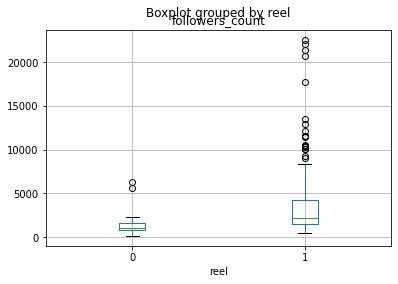

In [ ]:
# 処置群(Z = 1)と対照群(Z = 0)の個体数
print(data_mrms['reel'].value_counts())

# それぞれの群における結果変数の平均
print(data_mrms.groupby(['reel'])['followers_count'].mean())

# 処置と結果変数の関係を示す箱ひげ図
data_mrms.boxplot(column='followers_count', by='reel')

In [ ]:
data_mrms.groupby(['reel'])['log_followers_count'].mean()

reel
0    6.901708
1    7.916557
Name: log_followers_count, dtype: float64

このように、自分が関心のある「リールを投稿するか否か、がフォロワー数に影響するのではないか」という因果関係が実際に存在する可能性があることがわかる。

## 共変量

データの収集過程で、フォロワー数は男女で異なりそうだと感じた。<br>
性別と目的変数（フォロワー数）についても可視化する。後ほど他の変数についても、それぞれに注目し目的変数や介入との関係を調べる。

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


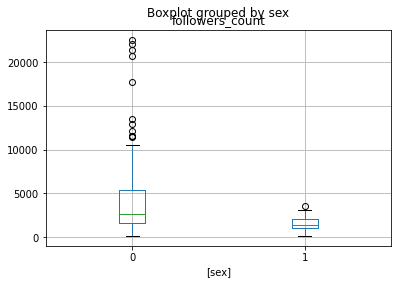

In [ ]:
data_mrms.boxplot(column='followers_count', by=['sex'])

箱ひげ図を見るとかなり男女差がありそう。

性別と介入（リールを投稿する）の関係についても確認する。分割表を作成する。

> [pandas.crosstab](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html)

In [ ]:
pd.crosstab(data_mrms['sex'], data_mrms['reel'])

reel,0,1
sex,,
0,21,77
1,9,43


（男女については層別に分ける、などの操作もありなのかもしれないと思った。ただしその場合の**問題点はサンプルが少なくなってしまうこと。だからただ層別に分けるのではなく傾向スコアを求めるのだろう。**）

このように男女で分けると「男性でリールを投稿していない人（男性の対照群）」がかなり少なくなってしまうことがわかる。

In [ ]:
print('sex = 0 : {0:.3f}, \nsex = 1 : {1:.3f}'.format(77 / (21 + 77), 43 / (9 + 43)))

sex = 0 : 0.786, 
sex = 1 : 0.827


この結果について「性別によって介入有無に差がある」と言えるかどうかを確認するために、独立性の検定を行う。

性別は目的変数に影響があるので共変量として扱うべきであると考えた。

### 独立性の検定

In [ ]:
table_x1_z = pd.crosstab(data_mrms['sex'], data_mrms['reel'], margins=True)
table_x1_z

reel,0,1,All
sex,,,
0,21,77,98
1,9,43,52
All,30,120,150


In [ ]:
print(30 * 98 / 150, (21 - 19.6) ** 2 / 19.6)
chi2 = 0
for i in range(2):
    for j in range(2):
        o = table_x1_z.loc[i, j]
        e = table_x1_z.loc[i, 'All'] * table_x1_z.loc['All', j] / table_x1_z.loc['All', 'All']
        print(o, e)
        chi2 += (o - e) ** 2 / e
print('chi2 : ', chi2, '\nchi2 < 3.84 : ', chi2 < 3.84)

19.6 0.09999999999999978
21 19.6
77 78.4
9 10.4
43 41.6
chi2 :  0.3605769230769231 
chi2 < 3.84 :  True


$0.36 < 3.84 = \chi_{0.05}^2(1)$ ,であるから有意水準5%で帰無仮説を棄却できない, すなわち独立でないとは言えない.  

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


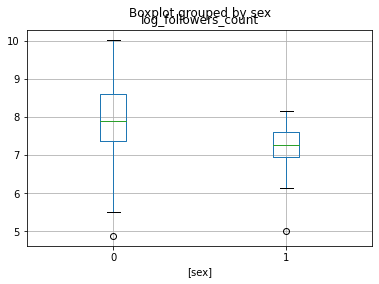

In [ ]:
data_mrms.boxplot(column='log_followers_count', by=['sex'])

### ただの層別解析

男性と女性でグループ分けして二つのデータフレームを作る。それぞれに対して介入と目的変数の関係を確認する。

In [ ]:
data_mr = data_mrms.query('sex == 1').reset_index()
data_ms = data_mrms.query('sex == 0').reset_index()

1    43
0     9
Name: reel, dtype: int64


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


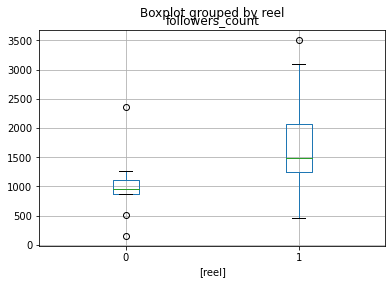

In [ ]:
print(data_mr['reel'].value_counts())
data_mr.boxplot(column='followers_count', by=['reel'])

1    77
0    21
Name: reel, dtype: int64


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


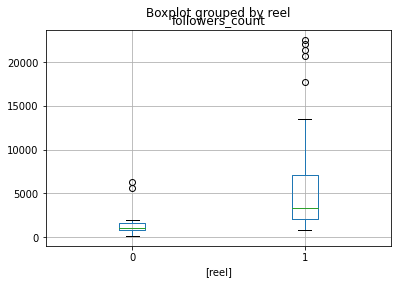

In [ ]:
print(data_ms['reel'].value_counts())
data_ms.boxplot(column='followers_count', by=['reel'])

### 共変量を探すための可視化

まずは $Z$ （リールの投稿有無）以外の変数と目的変数の関係を確認する。
<br>
得られている他のデータから `'follows_count'` と `'media_count'` が共変量 $X$ になりうると考えた。

これら2変数と目的変数についての相関係数行列を求める。

>[pandas.DataFrame.corr](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html)

In [ ]:
data_mrms[['followers_count', 'follows_count', 'media_count']].corr()

,followers_count,follows_count,media_count
followers_count,1.000000,0.189946,0.265898
follows_count,0.189946,1.000000,0.216226
media_count,0.265898,0.216226,1.000000


$Y$ と `'follows_count'` 列の相関係数は約0.190, $Y$ と `'media_count'` 列の相関係数は約0.266 であるからあまり相関はなさそう。

次に共変量と目的変数の散布図を描く。

先に`'follows_count'` と目的変数 $Y$ （フォロワー数）の関係を散布図で表す。

> [pandas.DataFrame.plot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html)

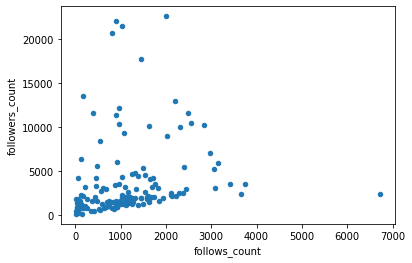

In [ ]:
import matplotlib.pyplot as plt

data_mrms.plot(x='follows_count', y='followers_count', kind='scatter')  # 散布図を描く

`'follows_count'` はほとんどの場合 $X \leq 4000$ となっているのに対し、一人だけ $X > 6000$ となっている個体を発見した。
<br>
次の二つの方法で外れ値の影響を除去する。
1. この外れ値を含まない `data_mrms2` を作成する。
2. `data_mrms` の中に `'follows_count'` の値に対して $\log$ をとった `'log_follows_count'` 列を作成する。

$log$ をとることでオーダーが異なるデータが扱いやすくなる。正規分布に近づくこともある。データの分布が正規分布に近づくことでデータ解析がしやすくなる。

                 followers_count  follows_count
followers_count         1.000000       0.230817
follows_count           0.230817       1.000000


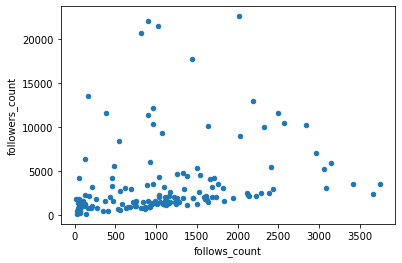

In [ ]:
# 外れ値を含まない data_mrms2 を作成
data_mrms2 = data_mrms.query('follows_count <= 4000')
print(data_mrms2[['followers_count', 'follows_count']].corr())
data_mrms2.plot(x='follows_count', y='followers_count', kind='scatter')  # 散布図を描く

確かに取り除けていることがわかる。相関係数はやや0から遠ざかったものの相関があるとは言えない。

次に `'follows_count'` 列のそれぞれの値を対数変換した新しい列を作る。
> [指数関数と対数関数](https://docs.python.org/ja/3/library/math.html#power-and-logarithmic-functions)

In [ ]:
import math

# follows_countのlogをとったlog_follows_count列を作成
data_mrms['log_follows_count'] = data_mrms['follows_count'].apply(lambda x: math.log(x))

# followers_countのlogをとったlog_followers_count列を作成
data_mrms['log_followers_count'] = data_mrms['followers_count'].apply(lambda x: math.log(x))

data_mrms[['followers_count', 'log_followers_count', 'follows_count', 'log_follows_count']]

,followers_count,log_followers_count,follows_count,log_follows_count
0,1455,7.282761,1637,7.400621
1,1990,7.595890,1612,7.385231
2,950,6.856462,868,6.766192
3,2091,7.645398,1682,7.427739
4,2356,7.764721,6728,8.814033
...,...,...,...,...
145,1464,7.288928,1049,6.955593
146,9043,9.109746,2027,7.614312
147,2060,7.630461,431,6.066108
148,3189,8.067463,218,5.384495


作成した `'log_follows_count'` 列と目的変数との関係を確認する。

**$\log$ だから相関係数は求めない？ <-- 
$\log$ が絡んでも相関係数を求める意味はある、とのこと。**

                   followers_count  log_follows_count
followers_count           1.000000           0.228816
log_follows_count         0.228816           1.000000


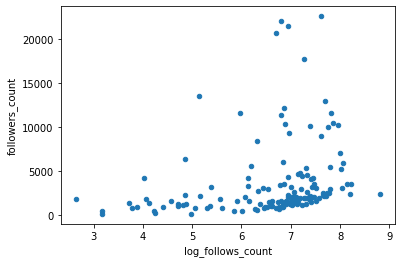

In [ ]:
print(data_mrms[['followers_count', 'log_follows_count']].corr())
data_mrms.plot(x='log_follows_count', y='followers_count', kind='scatter')  # 散布図を描く

$\log y$ と $\log x$ の関係も確認。 

                     log_followers_count  log_follows_count
log_followers_count             1.000000           0.428808
log_follows_count               0.428808           1.000000


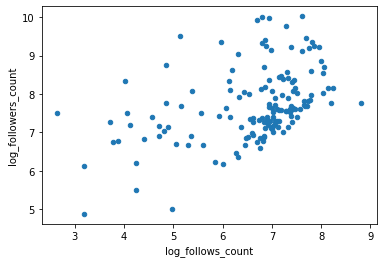

In [ ]:
print(data_mrms[['log_followers_count', 'log_follows_count']].corr())
data_mrms.plot(x='log_follows_count', y='log_followers_count', kind='scatter')  # 散布図を描く

`'log_followers_count'` を目的変数に（目的変数を対数変換）した場合 `'log_follows_count'`　は共変量になりそうだ。

目的変数を対数変換した時に処置と因果関係がありそうか、箱ひげ図で確認する。

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


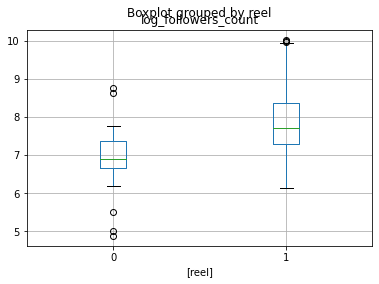

In [ ]:
data_mrms.boxplot(column='log_followers_count', by=['reel'])

因果関係がある可能性はありそうだ。

`'log_follows_count'` と処置の関係についてもみておく。

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


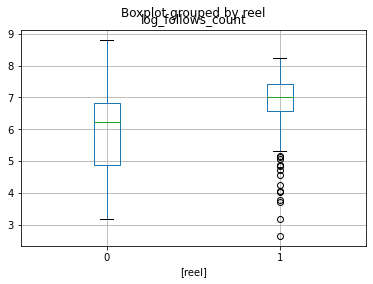

In [ ]:
data_mrms.boxplot(column='log_follows_count', by=['reel'])

独立ではなさそうだ。

`'log_follows_count'` は共変量として扱い傾向スコアを計算した方が良いだろう。

次に投稿数 `'media_count'` と目的変数 $Y$ （フォロワー数）の関係を散布図で表す。

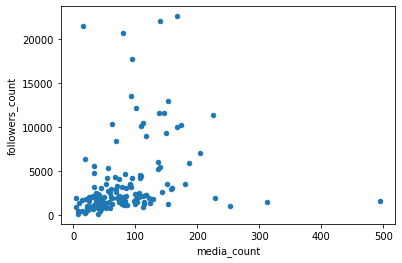

In [ ]:
data_mrms.plot(x='media_count', y='followers_count', kind='scatter')  # 散布図を描く

これについても $X$ の値のほとんどが $X \leq 300$ となっているのに対して、約500になっている個体が一人存在する。この外れ値の影響を先ほど同様２通りの方法で考慮する。

                 followers_count  media_count
followers_count          1.00000      0.33947
media_count              0.33947      1.00000


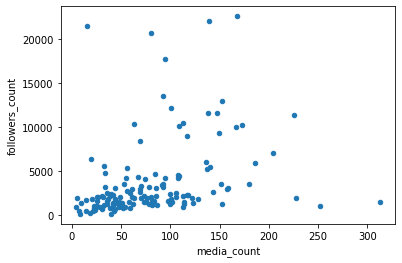

In [ ]:
# 投稿数の外れ値を含まない data_mrms3 を作成
data_mrms3 = data_mrms.query('media_count <=400')
print(data_mrms3[['followers_count', 'media_count']].corr())
data_mrms3.plot(x='media_count', y='followers_count', kind='scatter')  # 散布図を描く

In [ ]:
# media_countのlogをとった log_media_count列を作成
data_mrms['log_media_count'] = data_mrms['media_count'].apply(lambda x: math.log(x))
data_mrms[['follows_count', 'log_media_count']]

,follows_count,log_media_count
0,1637,4.290459
1,1612,4.143135
2,868,3.367296
3,1682,3.465736
4,6728,3.688879
...,...,...
146,1049,3.784190
147,2027,4.762174
148,431,4.382027
149,218,3.526361


                 followers_count  log_media_count
followers_count         1.000000         0.304359
log_media_count         0.304359         1.000000


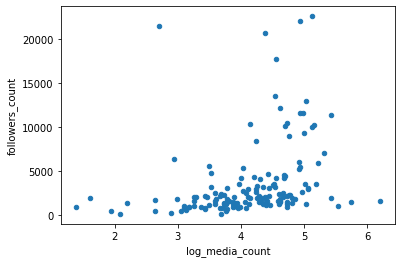

In [ ]:
# 作成した log_media_count 列と followers_countとの関係を確認
print(data_mrms[['followers_count', 'log_media_count']].corr())
data_mrms.plot(x='log_media_count', y='followers_count', kind='scatter')  # 散布図を描く

                     log_followers_count  log_media_count
log_followers_count             1.000000         0.467008
log_media_count                 0.467008         1.000000


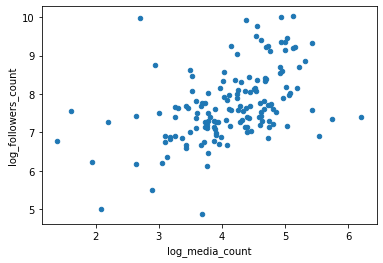

In [ ]:
# 作成した log_media_count 列と log_followers_countとの関係を確認
print(data_mrms[['log_followers_count', 'log_media_count']].corr())
data_mrms.plot(x='log_media_count', y='log_followers_count', kind='scatter')  # 散布図を描く

相関がありそうだ。

この `'log_media_count'` と `'reel'` の関係性も確認する。

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


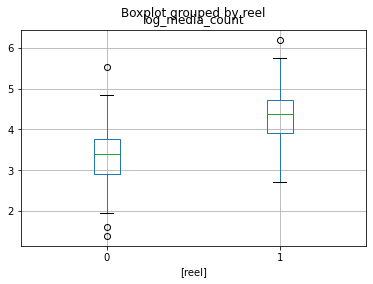

In [ ]:
data_mrms.boxplot(column='log_media_count', by=['reel'])

介入の有無にもは関係がありそうだ。

> [Stacking subplots in two directions](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html)
<br>
> [Artist customization in box plots](https://matplotlib.org/stable/gallery/statistics/boxplot.html)
<br>
> 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

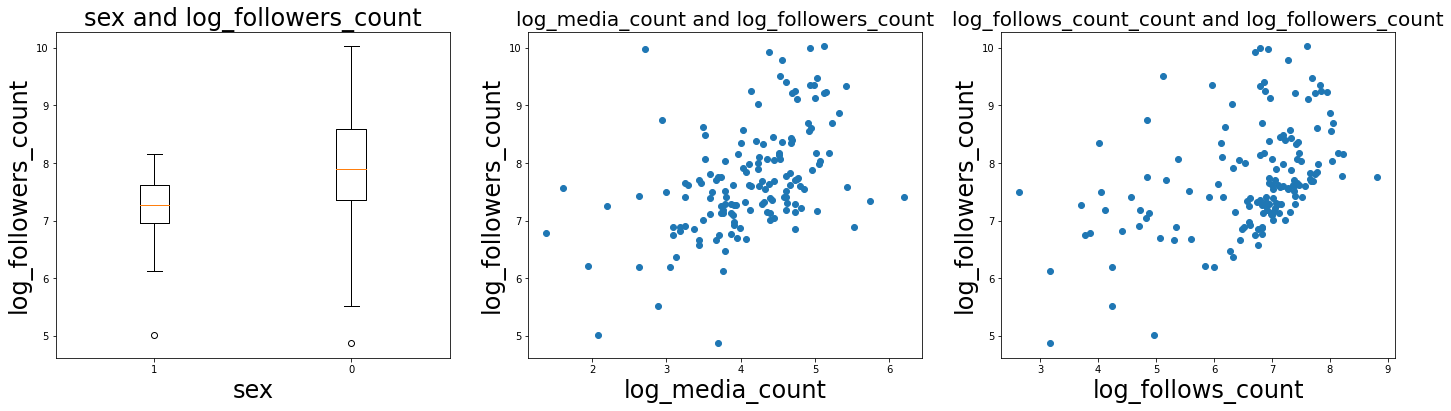

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))

fontdict = {'size': 24}

# 性別と結果変数の箱ひげ図
axs[0].boxplot(x=[data_mrms.query('sex == 1')['log_followers_count'], data_mrms.query('sex == 0')['log_followers_count']], labels = [1, 0])
#axs[0].set(xlabel='sex', ylabel='log_followers_count', fontdict=fontdict)
axs[0].set_xlabel('sex', fontdict=fontdict)
axs[0].set_ylabel('log_followers_count', fontdict=fontdict)
axs[0].set_title('sex and log_followers_count', fontdict=fontdict)
#axs[0].legend()

# 投稿数の対数と結果変数の散布図
axs[1].scatter(x=data_mrms['log_media_count'], y=data_mrms['log_followers_count'])
#axs[1].set(xlabel='log_media_count', ylabel='log_followers_count', fontdict=fontdict)
axs[1].set_xlabel('log_media_count', fontdict=fontdict)
axs[1].set_ylabel('log_followers_count', fontdict=fontdict)
axs[1].set_title('log_media_count and log_followers_count', fontdict=fontdict, fontsize=20)
#axs[1].legend()

# フォロー数の対数と結果変数の散布図
axs[2].scatter(x=data_mrms['log_follows_count'], y=data_mrms['log_followers_count'])
#axs[2].set(xlabel='log_follows_count', ylabel='log_followers_count', fontdict=fontdict)
axs[2].set_xlabel('log_follows_count', fontdict=fontdict)
axs[2].set_ylabel('log_followers_count', fontdict=fontdict)
axs[2].set_title('log_follows_count_count and log_followers_count', fontdict=fontdict, fontsize=20)
#axs[2].legend()

plt.savefig('plot_x_and_y.png')
files.download('plot_x_and_y.png')

plt.show()

In [ ]:
data_mrms[['log_follows_count', 'log_media_count', 'log_followers_count']].corr()

,log_follows_count,log_media_count,log_followers_count
log_follows_count,1.000000,0.374697,0.428808
log_media_count,0.374697,1.000000,0.467008
log_followers_count,0.428808,0.467008,1.000000


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

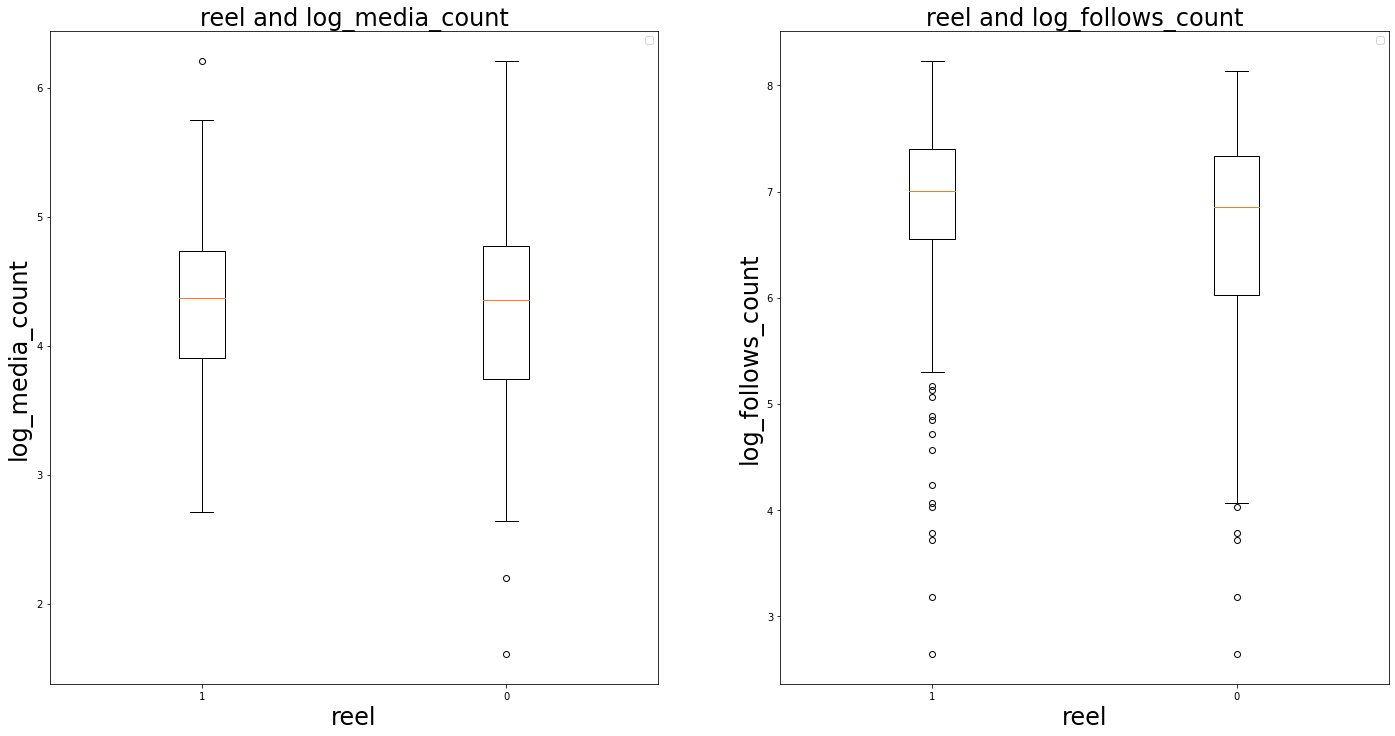

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 12))

fontdict = {'size': 24}

# 処置と投稿数の対数の箱ひげ図
axs[0].boxplot(x=[data_mrms.query('reel == 1')['log_media_count'], data_mrms.query('sex == 0')['log_media_count']], labels = [1, 0])
#axs[0].set(xlabel='reel', ylabel='log_media_count')
axs[0].set_xlabel('reel', fontdict=fontdict)
axs[0].set_ylabel('log_media_count', fontdict=fontdict)
axs[0].set_title('reel and log_media_count', fontdict=fontdict)
axs[0].legend()

# 投稿数の対数と結果変数の散布図
# 性別と結果変数の箱ひげ図
axs[1].boxplot(x=[data_mrms.query('reel == 1')['log_follows_count'], data_mrms.query('sex == 0')['log_follows_count']], labels = [1, 0])
#axs[1].set(xlabel='reel', ylabel='log_follows_count')
axs[1].set_xlabel('reel', fontdict=fontdict)
axs[1].set_ylabel('log_follows_count', fontdict=fontdict)
axs[1].set_title('reel and log_follows_count', fontdict=fontdict)
axs[1].legend()

plt.savefig('boxplot_z_and_x.png')
files.download('boxplot_z_and_x.png')

plt.show()

## 傾向スコア推定

「性別」と「対数変換した投稿数」と「対数変換したフォロー数」を共変量として傾向スコアを推定する。

>[sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

beta0: -2.101919178928087 
beta1 : 0.4340990990675911 
beta2: 1.1183593385403774 
beta3: -0.15281987495401522 
[0.8807438770793165, 0.8626033851253803, 0.743457657576332, 0.745169275952166, 0.7522620602454148, 0.8368380224523934, 0.8977004838503959, 0.9189926390751445, 0.8289758259128798, 0.7098121725440942, 0.9217203869023582, 0.9212981757904116, 0.9014411623668803, 0.9122223392563692, 0.912772835334706, 0.8111052511336032, 0.9274102810879937, 0.7053384059700888, 0.8504290653982239, 0.8197655820453755, 0.8535360138751376, 0.7040479744816187, 0.8695930678347119, 0.9214689279541819, 0.9207543503919589, 0.8360721892151178, 0.9323912044026715, 0.9249306709579473, 0.8224571182382858, 0.9202799135105351, 0.8746822177041446, 0.9196440571515014, 0.8784064076516456, 0.9027646556633551, 0.9327081491642504, 0.8978462076948026, 0.8072580531515426, 0.773540515207146, 0.868066740295611, 0.7573124908136456, 0.8162390587566731, 0.7995252214123091, 0.8597698255247569, 0.6779843503721494, 0.89786088281

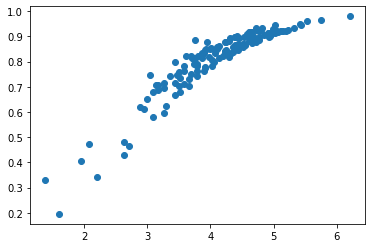

In [ ]:
import math
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


# シグモイド関数を定義
def func_sigmoid(x):
  return 1 / (1 + math.exp(-x))

Z = data_mrms['reel'] # 処置の割付けを表すダミー変数
X = data_mrms[['sex', 'log_media_count', 'log_follows_count']] # 共変量（性別と対数変換した投稿数と対数変換したフォロー数）

# ロジスティック回帰
model = LogisticRegression(solver="liblinear")
model.fit(X, Z)  # 学習

beta0 = model.intercept_[0]  # 切片項
beta1 = model.coef_[0][0]  # 回帰係数1
beta2 = model.coef_[0][1]  # 回帰係数2
beta3 = model.coef_[0][2]  # 回帰係数3
print('beta0: {0} \nbeta1 : {1} \nbeta2: {2} \nbeta3: {3} '.format(beta0, beta1, beta2, beta3))

# 傾向スコアの推定量を算出
Y = [beta0 + beta1 * X.at[i, 'sex'] + beta2 * X.at[i, 'log_media_count'] + beta3 * X.at[i, 'log_follows_count'] for i in range(len(data_mrms))]
ps = [func_sigmoid(y) for y in Y]
print(ps)

plt.scatter(X['log_media_count'], ps)  # シグモイド関数の形になっているか確認

`LogisticRegression(solver="liblinear")`の引数は `causallib` を参考にした。最適化の方法が違うとのこと。


ロジスティック回帰の結果について、係数の標準偏差や $z$ 値を求める。


In [ ]:
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm

logistic_model = smf.glm(formula = "reel ~ sex + log_media_count + log_follows_count", 
                       data = data_mrms, 
                       family=sm.families.Binomial(link=sm.genmod.families.links.logit())
                        )

logistic_result = logistic_model.fit() 
logistic_result.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   reel   No. Observations:                  150
Model:                            GLM   Df Residuals:                      146
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -53.142
Date:                Mon, 10 Jan 2022   Deviance:                       106.28
Time:                        08:12:13   Pearson chi2:                     190.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -7.2977      1.739     -4.196      0.000     -10.706      -3.889
sex                   0.7844      0.561      1.397      0.162      -0.316       1.885
log_media_count       1.9912      0.427      4.662      0.000       1.154       2.828
log_follows_count     0.1104      0.202      0.546      0.585      -0.286       0.507
=====================================================================================
"""

In [ ]:
# AICを求める
logistic_result.aic

114.28392826898772

p値が0.05未満のとき, その説明変数が結果変数に何らかの影響を与えていると考える.
<br>
今回は有意であると言える変数は `'log_media_count'` のみである.

In [ ]:
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm

logistic_model = smf.glm(formula = "reel ~ log_media_count", 
                       data = data_mrms, 
                       family=sm.families.Binomial(link=sm.genmod.families.links.logit())
                        )

logistic_result = logistic_model.fit() 
logistic_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   reel   No. Observations:                  150
Model:                            GLM   Df Residuals:                      148
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -54.677
Date:                Mon, 10 Jan 2022   Deviance:                       109.35
Time:                        08:13:33   Pearson chi2:                     234.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -6.3483      1.531     -4.147      0.000      -9.348      -3.348
log_media_count     1.9965      0.405      4.936      0.000       1.204       2.789
===================================================================================
"""

In [ ]:
# AICを求める
logistic_result.aic

113.35384641655878

Devianceで見ると差が4(説明変数の数*2)以下だから説明変数一個の方が良い

In [ ]:
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm

logistic_model = smf.glm(formula = "reel ~ log_media_count + log_follows_count", 
                       data = data_mrms, 
                       family=sm.families.Binomial(link=sm.genmod.families.links.logit())
                        )

logistic_result = logistic_model.fit() 
logistic_result.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   reel   No. Observations:                  150
Model:                            GLM   Df Residuals:                      147
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -54.173
Date:                Tue, 21 Dec 2021   Deviance:                       108.35
Time:                        09:09:59   Pearson chi2:                     196.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -7.1577      1.736     -4.123      0.000     -10.561      -3.755
log_media_count       1.8910      0.414      4.563      0.000       1.079       2.703
log_follows_count     0.1919      0.189      1.013      0.311      -0.179       0.563
=====================================================================================
"""

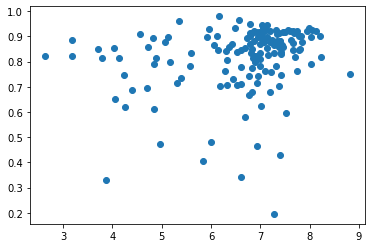

In [ ]:
plt.scatter(X['log_follows_count'], ps)  # シグモイド関数の形になっているか確認

共変量が複数あるからシグモイド関数の形になっていないのは仕方ない。

### 共変量のヒストグラム
共変量として選択した `'sex'`, `'log_media_count'`, `'log_follows_count'` のヒストグラムを描く.

> [pandas.DataFrame.hist](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7ff12ec4d0>,
      dtype=object)

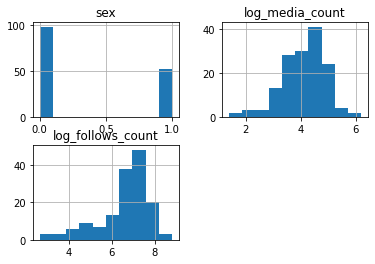

In [ ]:
X.hist()

傾向スコアのバランスを見るために, 横軸に傾向スコアを, 縦軸に確率密度をとったヒストグラムを描く. 

通常ヒストグラムの縦軸は度数だが, `plt.hist()` の引数 `density` を `True` にすることで確率密度に変えることができる. 

> [matplotlib.pyplot.hist](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html)
<br>
> [Pyplot Text](https://matplotlib.org/stable/gallery/pyplots/pyplot_text.html#sphx-glr-gallery-pyplots-pyplot-text-py)

Text(0, 0.5, 'density')

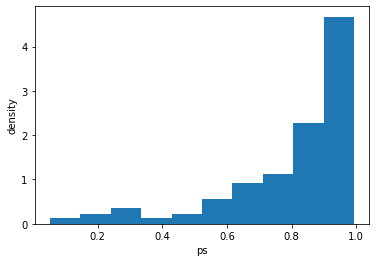

In [ ]:
plt.hist(ps, density=True)

plt.xlabel('ps')
plt.ylabel('density')

ここまでのヒストグラムを少し変えたものを出力する. 具体的には処置群と介入群の色を分けて, 2群のバランスを見る. 

そのために`data_mrms` に傾向スコアの列 `'ps'` を追加する. 

In [ ]:
data_mrms['ps'] = ps

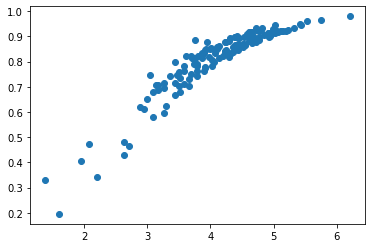

In [ ]:
plt.scatter(data_mrms['log_media_count'], data_mrms['ps'])  # シグモイド関数の形になっているか確認

以下と比較すると同じものであるようなので問題なさそう. 

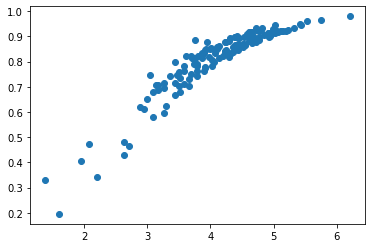

In [ ]:
plt.scatter(X['log_media_count'], ps)  # シグモイド関数の形になっているか確認

介入群と対照群のデータフレームを分ける.

In [ ]:
data_mrms_z1 = data_mrms.query('reel == 1').reset_index()
data_mrms_z0 = data_mrms.query('reel == 0').reset_index()

色付きのヒストグラムを作成.

> [matplotlib.pyplot.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html#matplotlib.pyplot.subplots)
<br>
> [matplotlib.axes.Axes.hist](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.hist.html#matplotlib.axes.Axes.hist)
<br>
> [Demo of the histogram function's different histtype settings](https://matplotlib.org/stable/gallery/statistics/histogram_histtypes.html#sphx-glr-gallery-statistics-histogram-histtypes-py)

## 逆確率による重み付け(IPW)

### ライブラリの活用

IPW推定量を求める. 

IBMが公開している [causallib](https://github.com/IBM/causallib) というライブラリを使った. 
<br>
まずはインストール.

In [ ]:
!pip install causallib

     |████████████████████████████████| 2.1 MB 5.4 MB/s 


IPWを実行する.

In [ ]:
from causallib.estimation import IPW
from causallib.evaluation import PropensityEvaluator
from sklearn.linear_model import LogisticRegression

# 目的変数と処置のダミー変数と共変量の変数を用意
Y = data_mrms['log_followers_count']  # 目的変数（対数変換したフォロワー数）
Z = data_mrms['reel'] # 処置の割付けを表すダミー変数
X = data_mrms[['sex', 'log_media_count', 'log_follows_count']] # 共変量（性別と対数変換した投稿数と対数変換したフォロー数）

# 学習
learner = LogisticRegression(solver="liblinear")
ipw = IPW(learner)
ipw.fit(X, Z)

# 重みの推定
outcomes = ipw.estimate_population_outcome(X, Z, Y)

# IPW推定量
effect = ipw.estimate_effect(outcomes[1], outcomes[0])
effect

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


diff    0.967653
dtype: float64

`effect` がIPW推定量であり, これが ATE の推定結果となる. 
<br>
今回の推定結果では 対数変換した目的変数の差が1なので, 処置の有無でフォロワー数が $e$ 倍になると解釈できる。$\log$ の差は真数の商なので.

In [ ]:
ipw.compute_weights(X, Z).head() # それぞれの重みを確認

0    1.135404
1    1.159281
2    3.897992
3    1.341977
4    4.036523
dtype: float64

In [ ]:
outcomes  # 重みの推定結果

1    7.909923
0    6.942270
dtype: float64

### IPWの実装

理解を深めるためにライブラリを使わず自力で実装してみる. 後ほど結果をライブラリを利用した場合と比較する.

In [ ]:
# 目的変数と処置のダミー変数と共変量の変数を用意
Y = data_mrms['log_followers_count']  # 目的変数（対数変換したフォロワー数）
Z = data_mrms['reel'] # 処置の割付けを表すダミー変数
X = data_mrms[['sex', 'log_media_count', 'log_follows_count']] # 共変量（性別と対数変換した投稿数と対数変換したフォロー数）

# 重みを計算
data_mrms['weight'] = data_mrms[['ps', 'reel']].apply(lambda x: 1 / x[0] if x[1] == 1 else 1 / (1 - x[0]), axis=1)

# 重みの推定
data_mrms['weight_logy'] = data_mrms[['log_followers_count', 'weight']].apply(lambda x: x[0] * x[1], axis=1)
#weight_y = data_mrms.groupby(by=['reel'])['weight_logy'].mean()  # N で割ったとき
#print(weight_y)
weight_y = data_mrms.groupby(by=['reel'])['weight_logy'].sum() / data_mrms.groupby(by=['reel'])['weight'].sum()  # 重みの和で割ったとき
print(weight_y)

# IPW推定量
ate = weight_y[1] - weight_y[0]
ate

reel
0    6.942270
1    7.909923
dtype: float64


0.9676526109078578

ライブラリで実行した際に得られたIPW推定量 `effect` と比較するとほぼ（全く？）同じ値であることがわかる.

In [ ]:
effect

diff    0.967653
dtype: float64

### IPWの漸近分散

$$\frac{1}{N^2} \sum_{i = 1}^N \left( \frac{Z_i(Y_i - \hat{E}[Y_1])^2}{\hat{e}_i^2} + \frac{(1 - Z_i)(Y_i - \hat{E}[Y_0])^2}{(1 - \hat{e}_i)^2} \right)$$

In [ ]:
S = 0
for i in range(150):
    z = data_mrms.at[i, 'reel']
    y = data_mrms.at[i, 'log_followers_count']
    e = data_mrms.at[i, 'ps']
    S += z * ((y - weight_y[1]) ** 2) / (e ** 2) + (1 - z) * ((y - weight_y[0]) ** 2) / ((1 - e) ** 2)
asymptotic_variance = S / (150 ** 2)
asymptotic_variance

0.01966717608869477

In [ ]:
import math
print(math.sqrt(0.01966717608869477))
print(0.967653 / math.sqrt(0.01966717608869477))


0.14023970938608923
6.8999929066879835


In [ ]:
data_mrms

,name,username,followers_count,biography,follows_count,media_count,sex,reel,movie_not_reel,reel_and_movie,log_follows_count,log_media_count,log_followers_count,ps,weight,weight_logy
0,鄭 幸陽 chenxingyang,chen_.x_y._,1455,◻️ミスター慶應理工コンテスト2021\n◻️慶應\n◻️理工学部応用化学科,1637,73,1,1,0,0,7.400621,4.290459,7.282761,0.880744,1.135404,8.268875
1,日比 琉偉,rui_hibi,1990,慶應義塾大学理工学部\nミスター慶應理工コンテスト準GP🥈\n用件のある方はDMまで🙇‍♂️,1612,63,1,1,1,1,7.385231,4.143135,7.595890,0.862603,1.159281,8.805773
2,伊藤 優之介,yunosu__1024,950,応援ありがとうございました📣,868,29,1,0,0,0,6.766192,3.367296,6.856462,0.743458,3.897992,26.726434
3,濤川 達也 |Namikawa Tatsuya,tatsuya._nami,2091,◽︎慶應義塾大学2年\n◽︎ミスター慶應理工2021\n◽︎湘南🌊/177cm\n◽︎お仕事...,1682,32,1,1,0,0,7.427739,3.465736,7.645398,0.745169,1.341977,10.259948
4,佐藤 ききよ,mr_keioygm21_5,2356,▪️ミスター慶應理工2021 GP👑\n▪️NEXT>>> MR OF MR CAMPUS ...,6728,40,1,0,1,0,8.814033,3.688879,7.764721,0.752262,4.036523,31.342476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,茅野 愛理 * Airi Chino,misstodai21_01,1464,ミス東大2021ファイナリスト\nLike: SKE48🧡パン🍞サラダ🥗ワイン🍷アイス🍨ギョ...,1049,44,0,1,1,1,6.955593,3.784190,7.288928,0.744066,1.343966,9.796073
146,長谷川遥花 Haruka Hasegawa,misstodai21_02,9043,沢山の応援ありがとうございました💗\n◯2002.5.5 (19)\n◯ミス東大2021準グ...,2027,117,0,1,0,0,7.614312,4.762174,9.109746,0.886983,1.127418,10.270490
147,千葉彩里衣/Sally Chiba,sally_._yllas,2060,‘01(19)\n𝘊𝘰𝘯𝘵𝘢𝘤𝘵→𝘥𝘮💌\nミス東大2021応援ありがとうございました❕,431,80,0,1,0,0,6.066108,4.382027,7.630461,0.866659,1.153856,8.804452
148,ミス東大No.4 上野万里,misstodai21_04,3189,東京大学文科二類2年\nミス東大2021グランプリ\n福岡出身\n2000.05.02,218,34,0,1,0,0,5.384495,3.526361,8.067463,0.734770,1.360970,10.979572


### IPWの前後比較

IPWを行う前の $E[Y^{(1)} | Z = 1] - E[Y^{(0)} | Z = 0]$ とIPW推定量を比較してみる。

In [ ]:
ave = data_mrms.groupby(by='reel')['log_followers_count'].mean()  # 重み付け前のlogyの平均
# 平均を比較
print('before　\n', 'z = 1 : {0:.3f}, z = 0 : {1:.3f}\n'.format(ave[1], ave[0]), 'after \n', 'z = 1 : {0:.3f}, z = 0 : {1:.3f}\n'.format(weight_y[1], weight_y[0]))  
# 平均の差を比較
print('before : {0}, after : {1}'.format(ave[1] - ave[0], ate))

before　
 z = 1 : 7.917, z = 0 : 6.902
 after 
 z = 1 : 7.910, z = 0 : 6.942

before : 1.0148480900247439, after : 0.9676526109078578


beforeよりもafterが小さくなっている.
<br>
**このことから共変量を考慮していなければ、因果効果を過大評価していたことがわかる.**

次に重みをかけた共変量の密度推定して共変量がバランスしたかを確認する.
<br>
$X$ のそれぞれの列に対して, 重みをかける前後の密度に関するヒストグラムを並べる. 左が調整前, 右が調整後である.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

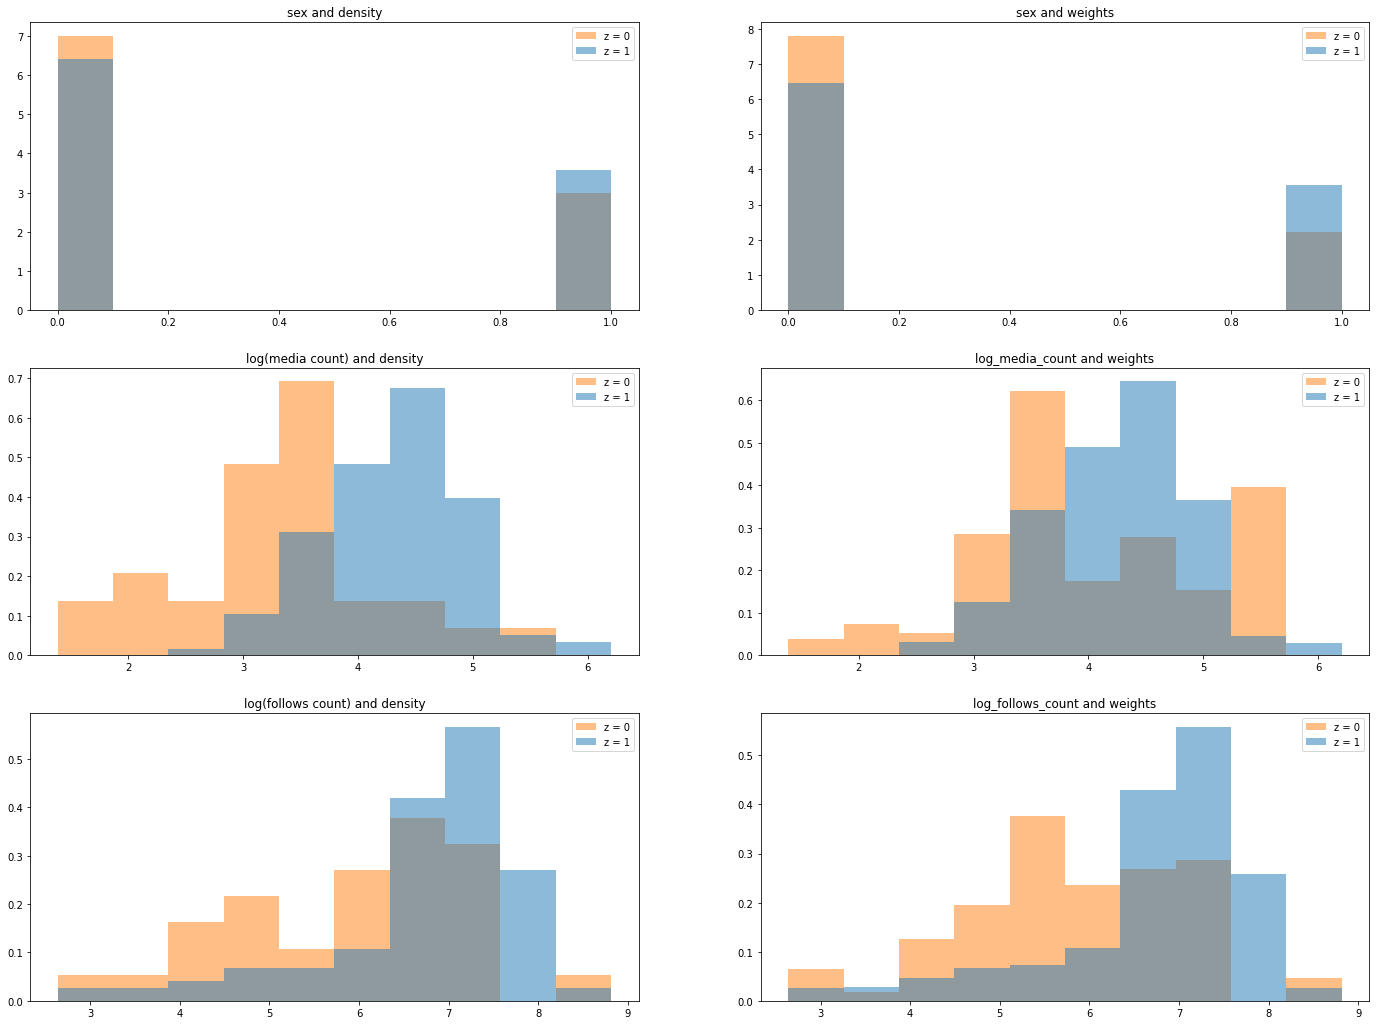

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(24, 18))

# 調整前の性別と確率密度のヒストグラム
axs[0, 0].hist(x=[data_mrms_z1['sex'], data_mrms_z0['sex']], density=True, histtype='stepfilled', alpha = 0.5, label=['z = 1', 'z = 0'])
axs[0, 0].set_title('sex and density')
axs[0, 0].legend()

# 調整後の性別と確率密度のヒストグラム
axs[0, 1].hist(x=[data_mrms_z1['sex'], data_mrms_z0['sex']], density=True, weights=[data_mrms_z1['weight'], data_mrms_z0['weight']], histtype='stepfilled', alpha = 0.5, label=['z = 1', 'z = 0'])
axs[0, 1].set_title('sex and weights')
axs[0, 1].legend()

# 調整前の投稿数を対数変換したものと確率密度のヒストグラム
axs[1, 0].hist(x=[data_mrms_z1['log_media_count'], data_mrms_z0['log_media_count']], density=True, histtype='stepfilled', alpha = 0.5, label=['z = 1', 'z = 0'])
axs[1, 0].set_title('log(media count) and density')
axs[1, 0].legend()

# 調整後の投稿数を対数変換したものと確率密度のヒストグラム
axs[1, 1].hist(x=[data_mrms_z1['log_media_count'], data_mrms_z0['log_media_count']], density=True, weights=[data_mrms_z1['weight'], data_mrms_z0['weight']], histtype='stepfilled', alpha = 0.5, label=['z = 1', 'z = 0'])
axs[1, 1].set_title('log_media_count and weights')
axs[1, 1].legend()

# 調整前のフォロー数を対数変換したものと確率密度のヒストグラム
axs[2, 0].hist(x=[data_mrms_z1['log_follows_count'], data_mrms_z0['log_follows_count']], density=True, histtype='stepfilled', alpha = 0.5, label=['z = 1', 'z = 0'])
axs[2, 0].set_title('log(follows count) and density')
axs[2, 0].legend()

# 調整後のフォロー数を対数変換したものと確率密度のヒストグラム
axs[2, 1].hist(x=[data_mrms_z1['log_follows_count'], data_mrms_z0['log_follows_count']], density=True, weights=[data_mrms_z1['weight'], data_mrms_z0['weight']], histtype='stepfilled', alpha = 0.5, label=['z = 1', 'z = 0'])
axs[2, 1].set_title('log_follows_count and weights')
axs[2, 1].legend()

plt.show()

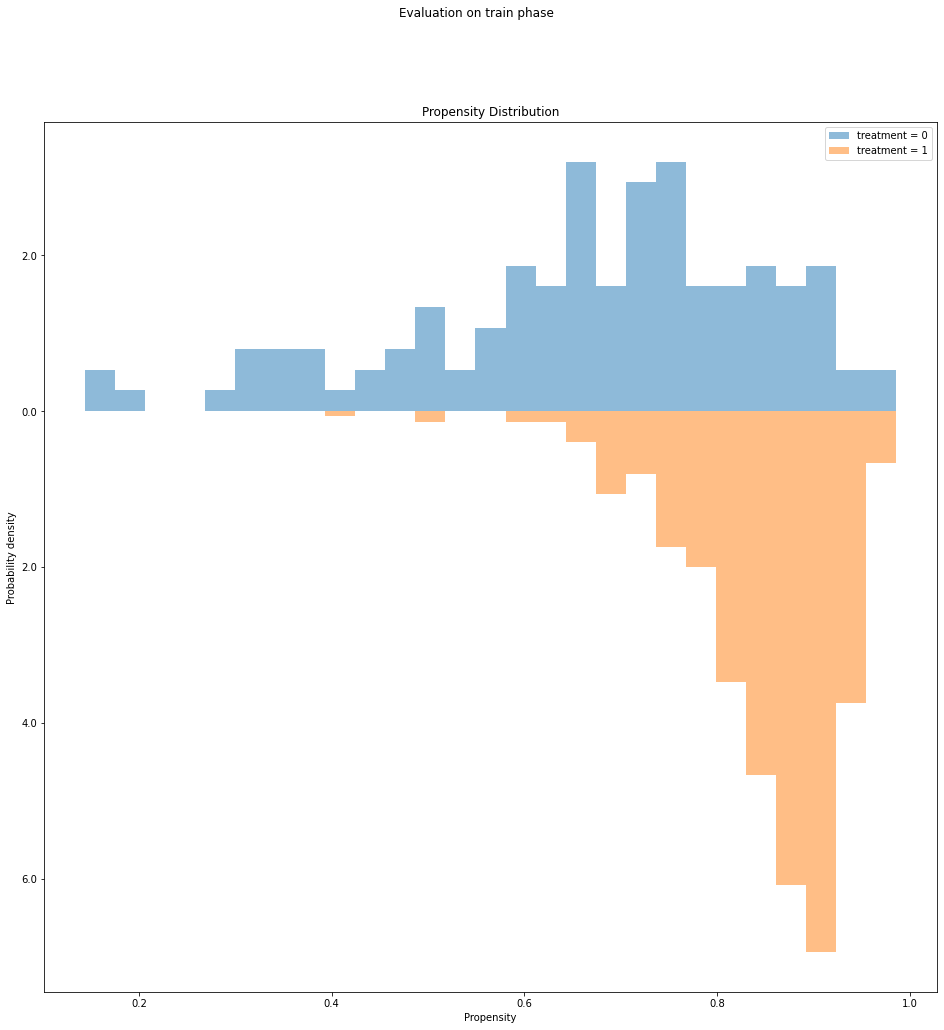

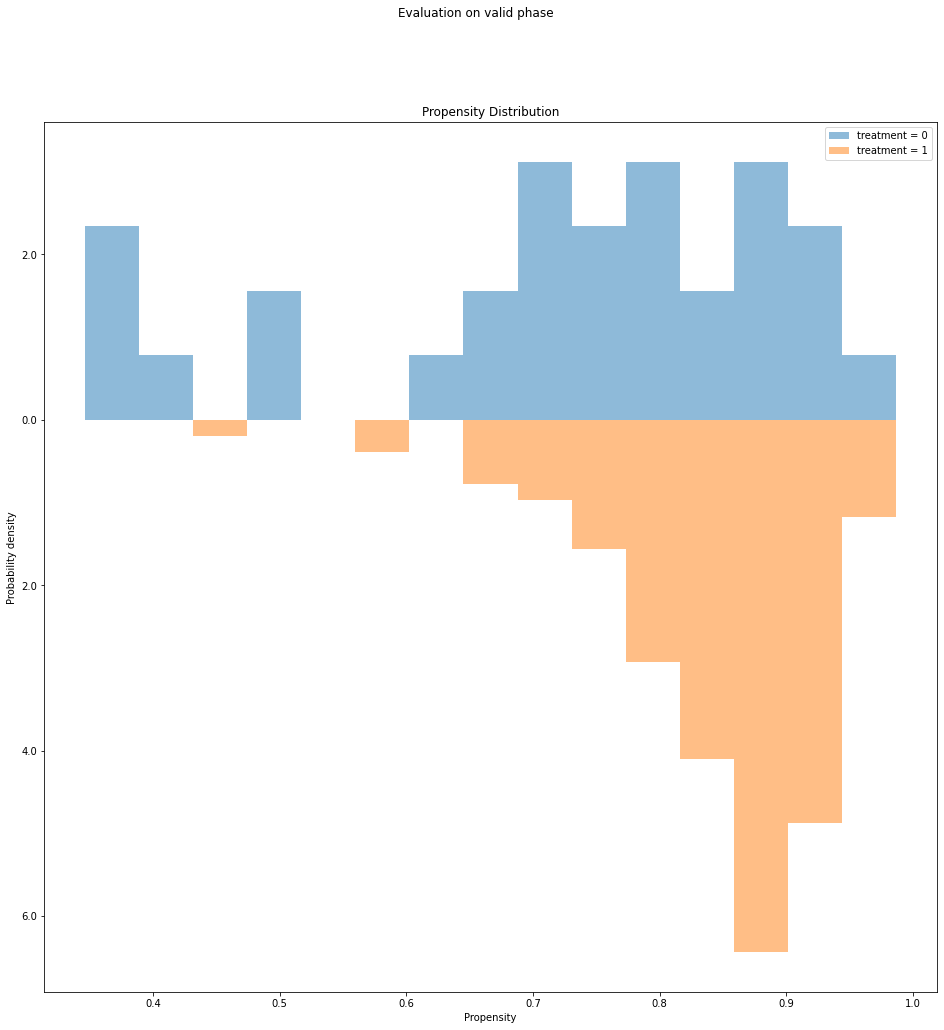

In [ ]:
evaluator = PropensityEvaluator(ipw)
results = evaluator.evaluate_cv(X, Z, Y, 
                                plots=["weight_distribution"])
results

以下共変量を `'log_media_count'` のみにしたとき.

In [ ]:
from causallib.estimation import IPW
from causallib.evaluation import PropensityEvaluator
from sklearn.linear_model import LogisticRegression

# 目的変数と処置のダミー変数と共変量の変数を用意
Y = data_mrms['log_followers_count']  # 目的変数（対数変換したフォロワー数）
Z = data_mrms['reel'] # 処置の割付けを表すダミー変数
X = data_mrms['log_media_count'] # 共変量（性別と対数変換した投稿数と対数変換したフォロー数）
X_fit = X.to_frame() 

# 学習
learner = LogisticRegression(solver="liblinear")
ipw = IPW(learner)
ipw.fit(X_fit, Z)

# 重みの推定
outcomes = ipw.estimate_population_outcome(X_fit, Z, Y)

# IPW推定量
effect = ipw.estimate_effect(outcomes[1], outcomes[0])
effect

diff    0.914554
dtype: float64

beta0: -2.2845869947258164 
beta1 : 0.9518074539176246
[0.85803986496685, 0.8400875346602067, 0.7151297692486132, 0.7338268902618332, 0.773208205216152, 0.8655486245510948, 0.9051828091217247, 0.9225998148890945, 0.8596099648937445, 0.7551430505772683, 0.9303734506419549, 0.9235012217406317, 0.917223714313523, 0.9239438861544594, 0.9161625917696503, 0.7812481427427105, 0.9078712940185447, 0.668143377484045, 0.8359192580229027, 0.8167327474391582, 0.8735476875544911, 0.768954704093529, 0.8838674594117505, 0.9345089703033733, 0.926080565099193, 0.8626453369810584, 0.9414334119675218, 0.9363933519239686, 0.7599328849863136, 0.9321601185605877, 0.8960521325454445, 0.9300044475624529, 0.8140034121035827, 0.8907717327327147, 0.9015863198123131, 0.8696743447289828, 0.8244471276875757, 0.8082851296844916, 0.8747867201765676, 0.7395083882177711, 0.7850515767610323, 0.7278828857206993, 0.8828070644215866, 0.6586963834080124, 0.9166966253735569, 0.8611447247458048, 0.8747867201765676, 0.902327896

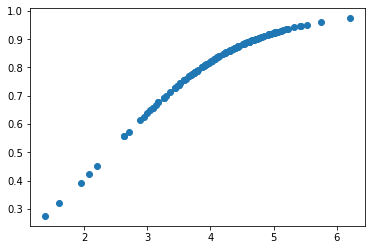

In [ ]:
import math
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


# シグモイド関数を定義
def func_sigmoid(x):
  return 1 / (1 + math.exp(-x))

Z = data_mrms['reel'] # 処置の割付けを表すダミー変数
X = data_mrms['log_media_count'] # 共変量（性別と対数変換した投稿数と対数変換したフォロー数）
X_fit = X.to_frame() 

# ロジスティック回帰
model = LogisticRegression(solver="liblinear")
model.fit(X_fit, Z)  # 学習f

beta0 = model.intercept_[0]  # 切片項
beta1 = model.coef_[0][0]  # 回帰係数1
print('beta0: {0} \nbeta1 : {1}'.format(beta0, beta1))

# 傾向スコアを計算
Y = [beta1 * x + beta0 for x in X]
ps = [func_sigmoid(y) for y in Y]
print(ps)

plt.scatter(X, ps)  # シグモイド関数の形になっているか確認

In [ ]:
data_mrms['ps2'] = ps

# 重みを計算
data_mrms['weight2'] = data_mrms[['ps2', 'reel']].apply(lambda x: 1 / x[0] if x[1] == 1 else 1 / (1 - x[0]), axis=1)

# 重みの推定
#data_mrms['weight_logy'] = data_mrms[['log_followers_count', 'weight']].apply(lambda x: x[0] * x[1], axis=1)
data_mrms['weight_logy_2'] = data_mrms[['log_followers_count', 'weight2']].apply(lambda x: x[0] * x[1], axis=1)
#weight_y = data_mrms.groupby(by=['reel'])['weight_logy'].mean()  # N で割ったとき
#print(weight_y)
weight_y_2 = data_mrms.groupby(by=['reel'])['weight_logy_2'].sum() / data_mrms.groupby(by=['reel'])['weight2'].sum()  # 重みの和で割ったとき
print(weight_y_2)

# IPW推定量
ate = weight_y_2[1] - weight_y_2[0]
ate

reel
0    6.975394
1    7.889948
dtype: float64


0.9145540484766546

In [ ]:
print(math.exp(0.968), math.exp(0.915))

2.6326738428088614 2.496775251904888


In [ ]:
## 漸近分散
S = 0
for i in range(150):
    z = data_mrms.at[i, 'reel']
    y = data_mrms.at[i, 'log_followers_count']
    e = data_mrms.at[i, 'ps2']
    S += z * ((y - weight_y_2[1]) ** 2) / (e ** 2) + (1 - z) * ((y - weight_y_2[0]) ** 2) / ((1 - e) ** 2)
asymptotic_variance = S / (150 ** 2)
asymptotic_variance

0.01777048382747067

In [ ]:
import math
print(math.sqrt(0.01777048382747067))
print(0.9145540484766546 / math.sqrt(0.01777048382747067))

0.133305978213547
6.860562899974387


$$\left|\frac{0.915}{\sqrt{0.018}} \right| = \frac{0.915}{0.133} = 6.86 > 1.96 = z_{0.025}$$

であるから、リールを投稿するかどうかでフォロワー数に差が生じると言える。

共変量の分布の変化を確認する。

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

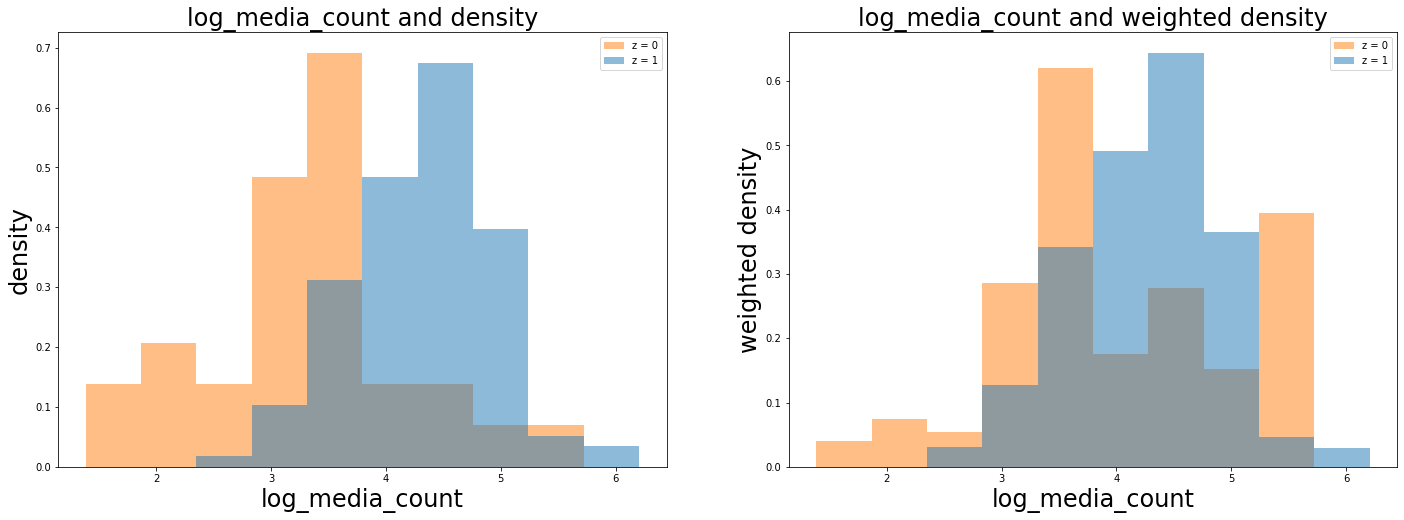

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

fontdict = {'size':24}

# 調整前の投稿数を対数変換したものと確率密度のヒストグラム
axs[0].hist(x=[data_mrms_z1['log_media_count'], data_mrms_z0['log_media_count']], density=True, histtype='stepfilled', alpha = 0.5, label=['z = 1', 'z = 0'])
axs[0].set_xlabel('log_media_count', fontdict=fontdict)
axs[0].set_ylabel('density', fontdict=fontdict)
axs[0].set_title('log_media_count and density', fontdict=fontdict)
axs[0].legend()

# 調整後の投稿数を対数変換したものと確率密度のヒストグラム
axs[1].hist(x=[data_mrms_z1['log_media_count'], data_mrms_z0['log_media_count']], density=True, weights=[data_mrms_z1['weight'], data_mrms_z0['weight']], histtype='stepfilled', alpha = 0.5, label=['z = 1', 'z = 0'])
axs[1].set_xlabel('log_media_count', fontdict=fontdict)
axs[1].set_ylabel('weighted density', fontdict=fontdict)
axs[1].set_title('log_media_count and weighted density', fontdict=fontdict)
axs[1].legend()

plt.savefig('ipw_balance_2.png')
files.download('ipw_balance_2.png')

plt.show()

調整をしたことで分布の偏りが小さくなっていることがわかった。